In [29]:
# | code-fold: hide

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.stats import qmc
from sklearn.datasets import fetch_openml
from sklearn.model_selection import ParameterGrid, train_test_split
from tqdm.notebook import tqdm

In [30]:
# | code-fold: hide

set_matplotlib_formats("svg")
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_context(context="notebook", font_scale=1.5)


warnings.filterwarnings("ignore", category=FutureWarning)
FIGSIZE = (12, 6)
N_SAMPLES = 100

# Introduction

We've all been in this situation. The point when we believe our features are good enough, and we're ready to train our first model. Initially, we start with the default settings of the model, which yields acceptable performance. However, to achieve better results, we determine that hyperparameter tuning is necessary. According to the Scikit-Learn documentation, there are several options: GridSearchCV and RandomizedSearchCV.

[Scikit-Learn](https://scikit-learn.org/stable/modules/classes.html#module-model_selection)


## Grid Search

GridSearchCV is a hyperparameter tuning method in Scikit-Learn that utilizes exhaustive search to determine the optimal combination of estimator parameters. It evaluates each set of specified parameter values by trying all possible combinations using cross-validation. The advantages of this approach include exhaustive exploration, providing detailed performance information. However, it is time-consuming and memory-intensive since it tests all combinations. The choice of cross-validation method and the number of folds significantly impact the results.


## RandomSearch

RandomizedSearchCV is a hyperparameter tuning method in Scikit-Learn that uses random sampling to search for the best combination of estimator parameters. Unlike GridSearchCV, which tries all possible combinations, it samples a fixed number of parameter settings from specified distributions. It is more efficient than exhaustive search but may not find the absolute best set of parameters. Cross-validation is used to evaluate each sampled set, and continuous or categorical distributions can be specified. The choice of distributions and iterations impacts results, as well as the cross-validation method and number of folds.

---

## Randomized Search for Hyperparameter Tuning

RandomizedSearchCV is a hyperparameter tuning method in Scikit-Learn that utilizes random sampling to find the optimal combination of estimator parameters. In contrast to GridSearchCV, which tests all possible combinations, RandomizedSearchCV samples a fixed number of parameter settings from specified distributions, making it more efficient in exploring the entire search-space. Cross-validation is employed to assess each sampled set, and continuous or categorical distributions can be defined. The chosen distributions, iterations, cross-validation method, and the number of folds all impact the results.


## Something in Between

There are techniques, such as Latin Hypercube Sampling (LHS) or [Poisson Disc sampling](https://www.youtube.com/watch?v=flQgnCUxHlw), that combine grid and random sampling methods.

Latin Hypercube Sampling is a deterministic, space-filling design technique that selects a representative sample from the parameter space. It does so by ensuring that every hyperrectangle enclosing each unique combination of parameters contains at least one sample. In simpler terms, LHS aims to provide a representative and uniform distribution of samples across the entire range of possible combinations.

Consider the analogy of a Sudoku puzzle. Each square on the board represents a unique combination of parameters. While you may be tempted to reveal all the numbers in one row or column, this would be unwise as it would limit the overall usefulness of your picks. LHS offers a framework for reducing the number of picks while maximizing their effectiveness. For instance, if you have selected a square from one row, it would favor other rows more, and the same logic applies to the columns and sub-squares.

![Sudoku Puzzle](artifacts/sudoku.png)

In conclusion, when choosing between hyperparameter tuning methods, it is essential to consider factors like computational resources, time constraints, and the complexity of the problem at hand. GridSearchCV offers exhaustive exploration but comes with higher computational costs, while RandomizedSearchCV provides flexibility and efficiency but may not find the absolute best combination of parameters. Latin Hypercube Sampling offers a balance between these two extremes by providing representative samples while being more computationally efficient than GridSearchCV for large search spaces.


## Visual Representation

To illustrate the distinction between the three sampling methods, let's consider a hypothetical scenario in a two-dimensional space, ranging from 0 to 1 inclusively, and apply the following three sampling strategies: random, Latin Hypercube Sampling (LHS), and grid.


In [31]:
# | code-fold: show
np.random.seed(99)

uni_sample = np.random.uniform(0, 1, (100, 2))

sampler = qmc.LatinHypercube(d=2, optimization="lloyd")
lhs_sample = sampler.random(n=100)

grid_sample = np.array(
    [[i, j] for i in np.linspace(0, 1, 10) for j in np.linspace(0, 1, 10)]
)

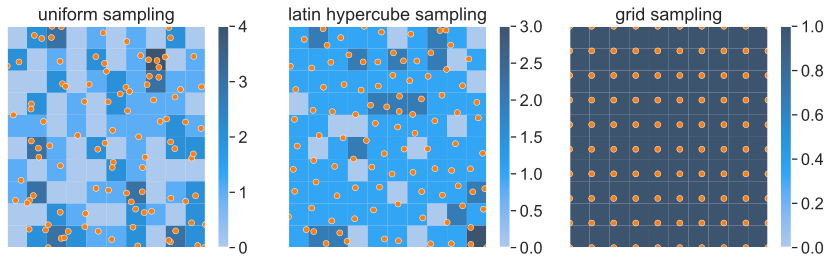

In [32]:
# | code-fold: hide

_, ax = plt.subplots(1, 3, figsize=(12, 4))


curr_ax = ax[0]
sns.histplot(
    x=uni_sample[:, 0], y=uni_sample[:, 1], bins=10, ax=curr_ax, cbar=True, thresh=None
)
sns.scatterplot(x=uni_sample[:, 0], y=uni_sample[:, 1], ax=curr_ax, color="tab:orange")
curr_ax.set_xticks([])
curr_ax.set_yticks([])
curr_ax.set_title("uniform sampling")


curr_ax = ax[1]
sns.histplot(
    x=lhs_sample[:, 0], y=lhs_sample[:, 1], bins=10, ax=curr_ax, cbar=True, thresh=None
)
sns.scatterplot(x=lhs_sample[:, 0], y=lhs_sample[:, 1], ax=curr_ax, color="tab:orange")
curr_ax.set_xticks([])
curr_ax.set_yticks([])
curr_ax.set_title("latin hypercube sampling")


curr_ax = ax[2]
sns.histplot(
    x=grid_sample[:, 0],
    y=grid_sample[:, 1],
    bins=10,
    ax=curr_ax,
    cbar=True,
    thresh=None,
)
sns.scatterplot(
    x=grid_sample[:, 0], y=grid_sample[:, 1], ax=curr_ax, color="tab:orange"
)
curr_ax.set_xticks([])
curr_ax.set_yticks([])
curr_ax.set_title("grid sampling")

plt.tight_layout()
plt.show()

The plots above illustrate that the random sampling method selects points randomly from the entire space, which can result in clustering or gaps. In contrast, Latin Hypercube Sampling ensures that each row and column contain a representative sample; however, it still generates a random pattern and disrupts the orthogonality of the grid sampling technique. Finally, the grid sampling method selects points at regular intervals, resulting in a uniform distribution across the space. Nevertheless, it may not be the most efficient method for large search spaces.


# Apply LHS to a Real Application

Let's put this knowledge into practice by performing some hyper-parameter tuning of a CatBoost model on the **[Portuguese Bank Marketing Dataset](https://www.openml.org/search?type=data&status=active&id=1461)**.

The dataset is related to direct marketing campaigns of a Portuguese banking institution, focusing on phone calls to promote term deposits. The data includes 17 input variables and one output variable. Input attributes consist of client demographics such as age, job type, marital status, education level, credit default status, average yearly balance, housing loan status, personal loan status, contact communication type, last contact day and month, duration of contact, number of contacts during the current campaign, number of days since last contact from a previous campaign, number of contacts before the current campaign, and the outcome of the previous marketing campaign. The goal is to predict if a client will subscribe to a term deposit based on these features.

This dataset represents a binary classification problem where the goal is to predict whether a client will subscribe to a term deposit based on multiple categorical and numerical features, making it an excellent use case for CatBoost, a gradient boosting library specifically designed to handle categorical data.


### Dataset

We can utilize the [`fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html#sklearn.datasets.fetch_openml) function from scikit-learn to automatically fetch the appropriate dataset. Following this, the data will be split into train and test sets with stratification controlled on the target variable. This ensures that the distribution of the target variable (y) remains equal for both the training and testing sets.


In [33]:
# | code-fold: show

# fetch data set
ID = 1461
X, y = fetch_openml(
    data_id=ID,
    data_home=f"openml_download_{ID}",
    return_X_y=True,
)

# downsample and create a stratified train test split
X = X.sample(frac=0.25)  # control the size of the dataset
X = X.dropna(axis=0, how="any")

# y = y.astype(int) - 1
y = y.loc[X.index]  # align the datasets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
)

## Information on the Dataset

The dataset consists of 9 categorical and 7 numerical features, making it suitable for use with CatBoost. This algorithm uses a specialized technique called "ordered target encoding" to convert categorical features into numerical values, which can improve model performance and accuracy in gradient boosting models. This approach is particularly effective when managing datasets with numerous categorical features compared to other machine learning algorithms.


In [34]:
# | code-fold: show

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11303 entries, 13121 to 3830
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      11303 non-null  int64   
 1   V2      11303 non-null  category
 2   V3      11303 non-null  category
 3   V4      11303 non-null  category
 4   V5      11303 non-null  category
 5   V6      11303 non-null  int64   
 6   V7      11303 non-null  category
 7   V8      11303 non-null  category
 8   V9      11303 non-null  category
 9   V10     11303 non-null  int64   
 10  V11     11303 non-null  category
 11  V12     11303 non-null  int64   
 12  V13     11303 non-null  int64   
 13  V14     11303 non-null  int64   
 14  V15     11303 non-null  int64   
 15  V16     11303 non-null  category
dtypes: category(9), int64(7)
memory usage: 807.6 KB


### Creating Data Pools

CatBoost offers the capability to create data pools. This feature enables CatBoost to optimize the handling of large files internally, providing benefits such as defining categorical features in one place for improved reproducibility and subsequent reuse.


In [35]:
# | code-fold: show

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=list(X.select_dtypes(include="category").columns),
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=list(X.select_dtypes(include="category").columns),
)

## Applying Three Sampling Techniques: Grid, Random, and Latin Hypercube

In the following section, we apply and compare the results of three sampling techniques: grid search, random search, and Latin Hypercube Sampling (LHS). Our objective is to demonstrate that LHS explores more of the design space than random search while maintaining sufficient randomness to mitigate the symmetry issues inherent in grid search.

The search space is defined by the following parameters:

- Depth: 1 to 15
- Iterations: 1 to 1024
- Subsample: 0.1 to 1
- Bagging Temperature: 1 to 1e6

We use 100 samples for each technique.


## Grid Search

To adhere to the limitation of 100 samples, we use $100^{1/4} \approx 3$, which results in $3^{4}=81$ samples.


In [36]:
# | code-fold: show

n_grid_samples = np.power(N_SAMPLES, 1 / 4)
n_grid_samples = np.floor(n_grid_samples).astype(int)

param_grid = {
    "depth": np.linspace(1, 15, n_grid_samples, dtype=int),
    "iterations": np.linspace(1, 1024, n_grid_samples, dtype=int),
    "subsample": np.linspace(0.1, 1, n_grid_samples, endpoint=False),
    "bagging_temperature": np.linspace(1, 1000000, n_grid_samples, dtype=int),
}

param_combo = list(ParameterGrid(param_grid=param_grid))

cube_search = []
start = time.time()
for param in param_combo:
    cbc = CatBoostClassifier(
        **param,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    score = cbc.get_best_score().get("validation").get("F1")
    param["score"] = score
    param["iterations"] = cbc.get_best_iteration()

    cube_search.append(param)
end = time.time()
print(f"time grid: {end - start:.2f} sec")
grid_results = pd.DataFrame(cube_search).sort_values(by="score", ascending=False)

time grid: 1538.35 sec


In [37]:
grid_results.head()

,bagging_temperature,depth,iterations,subsample,score
70,1000000,8,258,0.4,0.569507
43,500000,8,258,0.4,0.569507
16,1,8,258,0.4,0.569507
40,500000,8,216,0.4,0.565611
13,1,8,216,0.4,0.565611


## Random Search

For depth and iterations, the model expects integer values; therefore, `randint` is used. For subsample and bagging temperature, `uniform` is utilized since the model accepts float values for these parameters.


In [38]:
# | code-fold: show
random_sample = np.hstack(
    (
        np.random.randint(1, 15, (N_SAMPLES, 1)),
        np.random.randint(1, 1024, (N_SAMPLES, 1)),
        np.random.uniform(0, 1, (N_SAMPLES, 1)),
        np.random.uniform(1, 1_000_000, (N_SAMPLES, 1)),
    )
)

param_combo = list(
    pd.DataFrame(
        data=random_sample,
        columns=["depth", "iterations", "subsample", "bagging_temperature"],
    )
    .to_dict("index")
    .values()
)


cube_search = []
start = time.time()
for param in param_combo:
    cbc = CatBoostClassifier(
        **param,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    score = cbc.get_best_score().get("validation").get("F1")
    param["score"] = score
    param["iterations"] = cbc.get_best_iteration()

    cube_search.append(param)

end = time.time()
print(f"time random: {end - start:.2f} sec")
random_results = pd.DataFrame(cube_search).sort_values(by="score", ascending=False)

time random: 572.61 sec


In [39]:
# | code-fold: show

random_results.head()

,depth,iterations,subsample,bagging_temperature,score
58,7.0,437,0.281857,582472.959943,0.576497
11,7.0,343,0.437535,187632.443518,0.575893
91,5.0,713,0.207018,544578.689749,0.568233
89,9.0,214,0.658629,129890.179531,0.566893
65,8.0,369,0.606488,759745.435830,0.565022


## LHS Search

When applying the LHS (Latin Hypercube Sampling) technique, you need to specify the number of dimensions for the resulting sample and the number of samples you want. These parameters are on a different scale than the search space that you want to explore; therefore, a scaling is applied to adapt it to the desired space. Subsequently, a type conversion is applied.


In [40]:
# | code-fold: show
sampler = qmc.LatinHypercube(d=4, optimization="lloyd")
sample = sampler.random(n=N_SAMPLES)

l_bounds = [1, 1, 0, 1]
u_bounds = [15, 1024, 1, 1000000]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# convert to int
sample_scaled[:, :2] = sample_scaled[:, :2].astype(int)


param_combo = list(
    pd.DataFrame(
        data=sample_scaled,
        columns=["depth", "iterations", "subsample", "bagging_temperature"],
    )
    .to_dict("index")
    .values()
)

cube_search = []
start = time.time()
for param in param_combo:
    cbc = CatBoostClassifier(
        **param,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    score = cbc.get_best_score().get("validation").get("F1")
    param["score"] = score
    param["iterations"] = cbc.get_best_iteration()

    cube_search.append(param)

end = time.time()
print(f"time lhs: {end - start:.2f} sec")
lhs_results = pd.DataFrame(cube_search).sort_values(by="score", ascending=False)

time lhs: 527.88 sec


In [41]:
# | code-fold: show

lhs_results.head()

,depth,iterations,subsample,bagging_temperature,score
71,7.0,858,0.183817,282489.633420,0.577007
72,8.0,404,0.949294,368410.292079,0.573913
94,9.0,148,0.490337,655506.162010,0.570787
25,7.0,655,0.760262,385807.469267,0.568966
26,10.0,244,0.710746,567170.475059,0.566210


## Analysis of results


In [42]:
# | code-fold: show

df_all_sample = pd.concat(
    [
        lhs_results.assign(sampling="lhs"),
        random_results.assign(sampling="random"),
        grid_results.assign(sampling="grid"),
    ],
    axis=0,
)

df_all_sample = df_all_sample.sort_values(by="score", ascending=False)

df_all_sample.head(n=10)

,depth,iterations,subsample,bagging_temperature,score,sampling
71,7.0,858,0.183817,282489.633420,0.577007,lhs
58,7.0,437,0.281857,582472.959943,0.576497,random
11,7.0,343,0.437535,187632.443518,0.575893,random
72,8.0,404,0.949294,368410.292079,0.573913,lhs
94,9.0,148,0.490337,655506.162010,0.570787,lhs
16,8.0,258,0.400000,1.000000,0.569507,grid
43,8.0,258,0.400000,500000.000000,0.569507,grid
70,8.0,258,0.400000,1000000.000000,0.569507,grid
25,7.0,655,0.760262,385807.469267,0.568966,lhs
91,5.0,713,0.207018,544578.689749,0.568233,random


| Method | Time (sec) | Best Score |
| ------ | ---------- | ---------- |
| Grid   | 1538       | 0.569      |
| Random | 573        | 0.576      |
| LHS    | 528        | 0.577      |

Observing the time taken by each method, it is evident that grid search is the slowest, followed by random search and then LHS. This outcome is expected, as grid search is the most exhaustive search method, utilizing a large number of search points with high values for iterations (which control the number of trees in the model). In comparison, random search and LHS are faster than grid search due to having fewer points with high-value iterations. The difference is significant, with a reduction factor in runtime of around 3.

From a scoring perspective, the LHS method identified a set of hyperparameters that achieved the highest score. Random search followed closely behind, while grid search performed the worst.


# Bonus: Optuna Hyperparameter Optimization Framework

[Optuna](https://optuna.readthedocs.io/en/stable/) provides a better way to perform hyperparameter optimization. With Optuna, you can define the search space and objective function, allowing Optuna to handle the rest. It utilizes a Bayesian optimization algorithm to find the best hyperparameters for your model. This dynamically adjust the search space, balancing exploration and exploitation. Resulting in faster convergence towards more optimal hyperparameters.


In [43]:
# | code-fold: show


def obj_all(trial) -> float:
    params = {
        "depth": trial.suggest_int(name="depth", low=1, high=15),
        "iterations": trial.suggest_int("iterations", 1, 1024),
        "subsample": trial.suggest_float("subsample", 0, 1.0),
        "bagging_temperature": trial.suggest_float(
            "bagging_temperature", 1e-10, 1_000_000, log=True
        ),
    }

    cbc = CatBoostClassifier(
        **params,
        eval_metric="F1",
    )
    cbc.fit(train_pool, eval_set=(test_pool), verbose=False)

    return cbc.get_best_score().get("validation").get("F1")


print("-" * 10)

start = time.time()
study = optuna.create_study(study_name="all-in", direction="maximize")
study.optimize(
    obj_all,
    n_trials=N_SAMPLES,
)

end = time.time()
print("-" * 10)
print(f"time all-in: {end - start:.2f} sec")
print(f"{study.best_params=}")
print(f"{study.best_value=}")

[I 2024-04-04 10:56:47,456] A new study created in memory with name: all-in


----------


[I 2024-04-04 10:56:50,953] Trial 0 finished with value: 0.5277777777777778 and parameters: {'depth': 11, 'iterations': 372, 'subsample': 0.6351383146436217, 'bagging_temperature': 2.0916398414638855e-07}. Best is trial 0 with value: 0.5277777777777778.
[I 2024-04-04 10:58:11,784] Trial 1 finished with value: 0.47117794486215536 and parameters: {'depth': 15, 'iterations': 783, 'subsample': 0.16383410905600349, 'bagging_temperature': 732719.8112932495}. Best is trial 0 with value: 0.5277777777777778.
[I 2024-04-04 10:58:14,578] Trial 2 finished with value: 0.5263157894736843 and parameters: {'depth': 4, 'iterations': 684, 'subsample': 0.5639112261921894, 'bagging_temperature': 2.322972999138206e-06}. Best is trial 0 with value: 0.5277777777777778.
[I 2024-04-04 10:58:14,640] Trial 3 finished with value: 0.3699421965317919 and parameters: {'depth': 1, 'iterations': 33, 'subsample': 0.2177368073237087, 'bagging_temperature': 4.4335773709225747e-07}. Best is trial 0 with value: 0.527777777

----------
time all-in: 589.39 sec
study.best_params={'depth': 8, 'iterations': 716, 'subsample': 0.10728942137717945, 'bagging_temperature': 2.4918303179984774e-05}
study.best_value=0.5758241758241759


| Method | Time (sec) | Best Score |
| ------ | ---------- | ---------- |
| Grid   | 1538       | 0.569      |
| Random | 573        | 0.576      |
| LHS    | 528        | 0.577      |
| Optuna | 589        | 0.575      |

In this case, when limiting Optuna to sample only 100 points, it runs in roughly the same time as Random and LHS, yielding a similar score. In theory, increasing the number of sampled points by Optuna should result in a higher best score. However, this was not observed in the present scenario.


In [44]:
# |echo: false
# |output: false
import gif

In [45]:
# |echo: false
# |output: false
# function that plots a single frame
@gif.frame
def frame(sub_lhs_sample):
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    curr_ax = ax
    sns.histplot(
        x=sub_lhs_sample[:, 0],
        y=sub_lhs_sample[:, 1],
        bins=10,
        ax=curr_ax,
        cbar=False,
        thresh=None,
    )
    sns.scatterplot(
        x=sub_lhs_sample[:, 0],
        y=sub_lhs_sample[:, 1],
        ax=curr_ax,
        color="tab:orange",
        s=100,
    )
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])


# frame(lhs_sample)

In [46]:
# |echo: false
# |output: false
# creating a sample of lhs for the gif
sampler = qmc.LatinHypercube(d=2, optimization="lloyd")
lhs_sample = sampler.random(n=300)

n_slices = 33
inc = lhs_sample.shape[0] // n_slices

prev_i = 0
all_frames = []
for i in range(inc, lhs_sample.shape[0], inc):
    all_frames.append(frame(lhs_sample[prev_i:i, :]))

In [47]:
# |echo: false
# |output: false
# add the bounce, reverse the frames and add them
all_frames.extend(all_frames[::-1])

In [48]:
# |echo: false
# |output: false
# save the gif
gif.save(all_frames, "artifacts/dots.gif", duration=100)